# Exposin Project
Author: Chris Andre

The exposin project implements the exponential sinusoid trajectory model into the ESA's PyKEP trajectory analysis software package. The trajectory is implemented in the lambert boundary value parameterization in tuned C++ with Python bindings for ease of use.

[1] The reference paper for the Lambert problem for exponential sinusoids is http://www.esa.int/gsp/ACT/doc/MAD/pub/ACT-TNT-MAD-LMSP01.pdf

[2] The paper used for validation of results is http://www.esa.int/gsp/ACT/doc/ARI/ARI%20Study%20Report/ACT-RPT-MAD-ARI-05-4106-Spiral%20Trajectories%20in%20Global%20Optimisation.pdf

# Project Implementation State
The core features are done. Optimizations have been tuned.

The C++ implementation, the Python bindings, some plotting and output convenience functions are implemented.
## Python Bindings
Classes representing the Lambert BVP for exposins and exposins themselves are exposed:

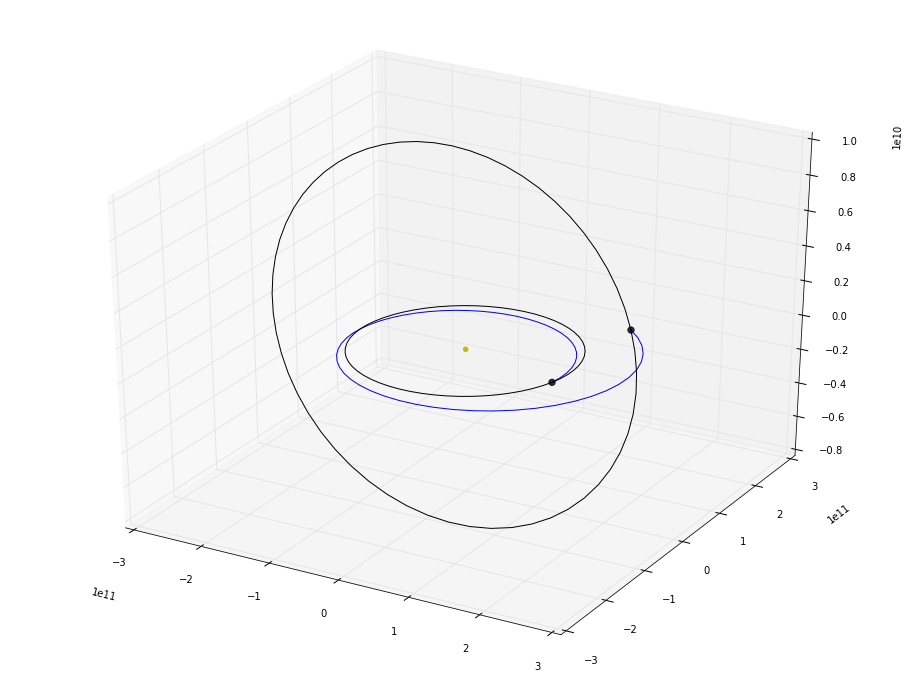

In [1]:
'''
Plot an example transfer
'''
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

import PyKEP

earth = PyKEP.planet.jpl_lp('earth')
mars = PyKEP.planet.jpl_lp('mars')
k2 = 0.6
n = -1
t0 = 250.0
tof = 520.0
lw = False

r1, v1 = earth.eph(PyKEP.epoch(t0,"mjd2000"))
r2, v2 = mars.eph(PyKEP.epoch(t0+tof,"mjd2000"))

prob = PyKEP.lambert_exposin(r1, r2, tof * PyKEP.DAY2SEC, PyKEP.MU_SUN, lw, n, k2)

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
axis = fig.gca(projection='3d')

axis.scatter([0],[0],[0],color='y')

PyKEP.orbit_plots.plot_lambert_exposin(prob, axis)
PyKEP.orbit_plots.plot_planet(earth, PyKEP.epoch(t0,"mjd2000"), ax=axis)
PyKEP.orbit_plots.plot_planet(mars, PyKEP.epoch(t0+tof,"mjd2000"), ax=axis)

plt.show()

REPL functionality and some other readout functions are implemented:

In [2]:
print prob
exps = prob.get_exposins()
isp = 5000
mass = 4000
print 'Exposin details:'
for ex in exps:
    print '-'
    print 'Mass: %.1f kg -> %.1f kg'            % (mass, ex.get_final_mass(PyKEP.MU_SUN, isp, mass))
    print 'Maximum thrust needed: %.3f N'       % ex.get_maximum_thrust(PyKEP.MU_SUN, isp, mass)
    print 'Low-thrust delta-v: %.3f m/s'        % ex.get_delta_v(PyKEP.MU_SUN)
    print 'Revolutions: %i'                     % ex.get_revs()
    print 'Total angle traversed: %.1f degrees' % (ex.get_psi() * PyKEP.RAD2DEG)

Lambert's problem (exponential sinusoid)
mu: 1.32712440018e+20
tof: 44928000
k2: 0.6
r1: [145390691387.56271, -39836057046.034431, 72132.884386920807]
r2: [145137665666.18463, 165095085371.10519, -108099519.60066652]
lw: 0
transfer angle: 1.117070105991179
has solutions? 1
num solutions: 1
min revs: 1
max revs: 1
solutions: 1
Rev: 1, v1: [3967.4082875343129, 30081.059390769278, -16.455472497816146], v2: [-18193.53496194262, 14909.819739693357, -5.2495991428533637]
Exposin:  k0: 170609572323.6577 k1: -0.2599308102255781 k2: 0.6 phi: 0.4962416131664902


Exposin details:
-
Mass: 4000.0 kg -> 3560.3 kg
Maximum thrust needed: 0.891 N
Low-thrust delta-v: 5664.432 m/s
Revolutions: 1
Total angle traversed: 424.0 degrees


In all, the Python bindings contain:

`lambert_exposin` object
* get_v1()
* get_v2()
* get_r1()
* get_r2()
* get_tof()
* get_mu()
* get_transfer_angle()
* get_k2()
* has_solutions()
* num_solutions()
* min_revs()
* max_revs()
* get_exposins()

`exposin` object (no constructor)
* get_tof(psi,mu)
* get_theta(tof,mu)
* get_state(theta,mu)
* get_psi()
* get_revs()
* get_transfer_angle()
* get_final_mass(mu,isp,mass)
* get_maximum_thrust(mu,isp,mass)
* get_delta_v(mu)


A graphing utility in `orbit_plots`

## C++ backend
* `lambert_exposin`, `class_exposin`, and `exposin` classes are fully implemented

* `lambert_exposin` provides the solutions to a Lambert BVP.

* `class_exposin` handles the relevant exposin space for `lambert_exposin` and handles TOF searching - I do not think it is useful alone, so I did not create bindings in Python.

* `exposin` represents a single exponential sinusoid trajectory.

A few tuning parameters are set at the top of each file (mostly tolerances and iteration limits).

## Speed in comparison to conic lambert solver

In [3]:
setup = '''
import PyKEP as pk
r1 = [149.0e9, 0.0, 0.0]
r2 = [300.0e9, -100.0e9, 0.0]
mu = 1.32e20
tof = 86400 * 550.0
lw = True
N = 0
k2 = 0.2
'''
import timeit
t_exp = timeit.repeat("pk.lambert_exposin(r1,r2,tof,mu,lw,N,k2)", setup, number=5000)
t_lam = timeit.repeat("pk.lambert_problem(r1,r2,tof,mu,lw,N)", setup, number=5000)

print 'Time ratio: %.2fx' % (max(t_exp)/min(t_lam))

Time ratio: 3.46x


### Earth-Apophis Transfer Example
This example reimplements the transfer example given in [2]. The resulting graph appears to match the results in [2].

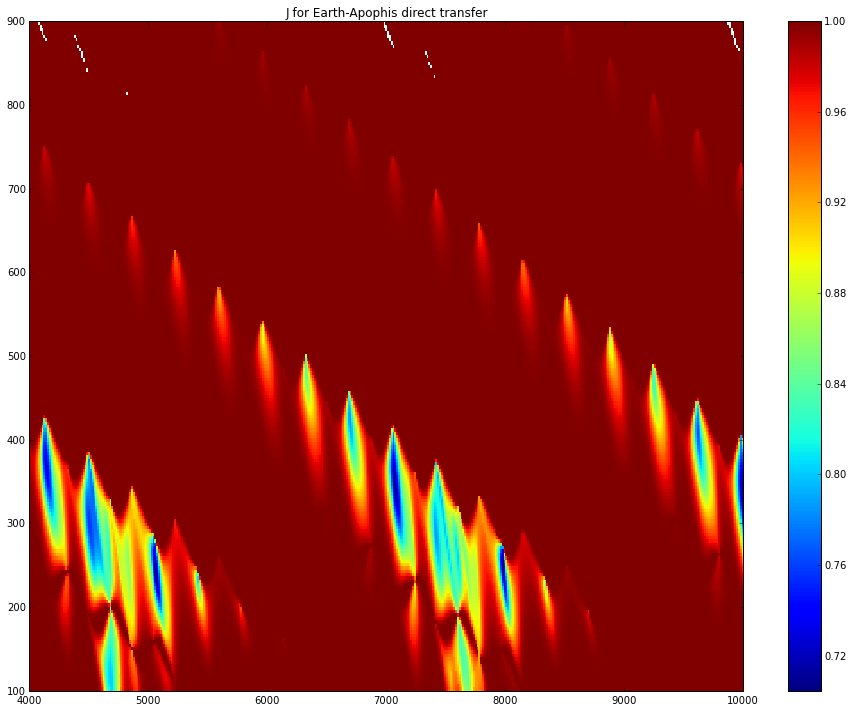

In [4]:
'''
This code will produce a porkchop plot of the J function over a range of launch times and flight times
for a transfer between Earth and Apophis.
'''
import math
import numpy
import PyKEP as pk
import matplotlib.pyplot as plt
import Vector

p1 = pk.planet.jpl_lp('earth')
p2 = pk.planet.mpcorb('99942   19.2   0.15 K107N 202.49545  126.41859  204.43202    3.33173  0.1911104  1.11267324   0.9223398  1 MPO164109  1397   2 2004-2008 0.40 M-v 3Eh MPCAPO     C802  (99942) Apophis            20080109')
k2 = 0.6
n = 0
isp_chem = 350
isp_lt = 4000

t0_range = [4000, 10000]
tof_range = [100, 900]

@numpy.vectorize
def J(t0, tof):
    ep1 = pk.epoch(t0)
    ep2 = pk.epoch(t0 + tof)
    r1, v1 = p1.eph(ep1)
    r2, v2 = p2.eph(ep2)
    resJ = []
    for longway in [True, False]:
        prob = pk.lambert_exposin(r1, r2, tof * pk.DAY2SEC, pk.MU_SUN, longway, n, k2)
        for i in range(prob.num_solutions()):
            exps = prob.get_exposins()[i]
            dv1 = Vector.mag(Vector.sub(prob.get_v1()[i], v1))
            dv2 = Vector.mag(Vector.sub(prob.get_v2()[i], v2))
            dvlt = exps.get_delta_v(pk.MU_SUN)
            resJ.append(1.0 - math.exp(-(dv1 + dv2) / 9.81 / isp_chem - dvlt / 9.81 / isp_lt))
    if len(resJ) == 0:
        return numpy.nan
    else:
        return numpy.nanmin(resJ)

t0 = numpy.linspace(t0_range[0], t0_range[1], 400)
tof = numpy.linspace(tof_range[0], tof_range[1], 200)
X, Y = numpy.meshgrid(t0, tof)
Z = J(X, Y)
mZ = numpy.ma.array(Z, mask=numpy.isnan(Z))
plt.figure()
plt.pcolor(X, Y, mZ, vmin=numpy.nanmin(Z), vmax=numpy.nanmax(Z))
plt.colorbar()
plt.title('J for Earth-Apophis direct transfer')
plt.show()